# **7. Conclusion et évaluation**

### **Conclusion**

Dans ce cours, nous avons vu comment on pouvait atomiser un processus en différentes petites tâches qui peuvent communiquer entre elles, s'enchaînent et peuvent être conditionnées sur leur réussite ou échec. Nous avons vu comment Airflow apportait une plateforme de gestion des processus, des utilisateurs, des droits de ces utilisateurs.

Airflow est un outil très utilisé en Data Engineering aujourd'hui, notamment pour gérer les `ETL` et `ELT` récurrents ou non.

### **Bonnes pratiques**

Dans ce paragraphe, nous allons voir quelques bonnes pratiques dans l'utilisation d'Airflow:

- réduire au maximum la taille des tâches pour qu'elles puissent tourner ou re-tourner de manière indépendantes
- éviter de faire tourner du code en dehors de la définition des tâches et des `DAGs` dans le dossier `dags`
- éviter d'utiliser Airflow pour des tâches sur de trop gros volumes de données: préférer lancer des tâches sur des moteurs de calcul dédiés (Spark, Hadoop, SQL, ...)
- contrairement à ce que nous avons fait dans le cours, préférer un `start_date` statique
- passer la plupart des arguments communs aux différentes tâches dans l'argument `default_args` dans la définition du `DAG`
- éviter de supprimer des tâches dans un `DAG` pour conserver l'historique d'exécution de ces tâches: préférer construire un nouveau `DAG`
- implémenter des tâches de vérifications avec des `Sensors` notamment après des insertions
- bien documenter les tâches et les `DAG`

### **Évaluation**

Pour l'évaluation de ce cours, nous allons construire un `DAG` qui permet de récupérer des informations depuis une API de données météo disponible en ligne, les stocke, les transforme et entraîne un algorithme dessus. Son architecture sera la suivante:  

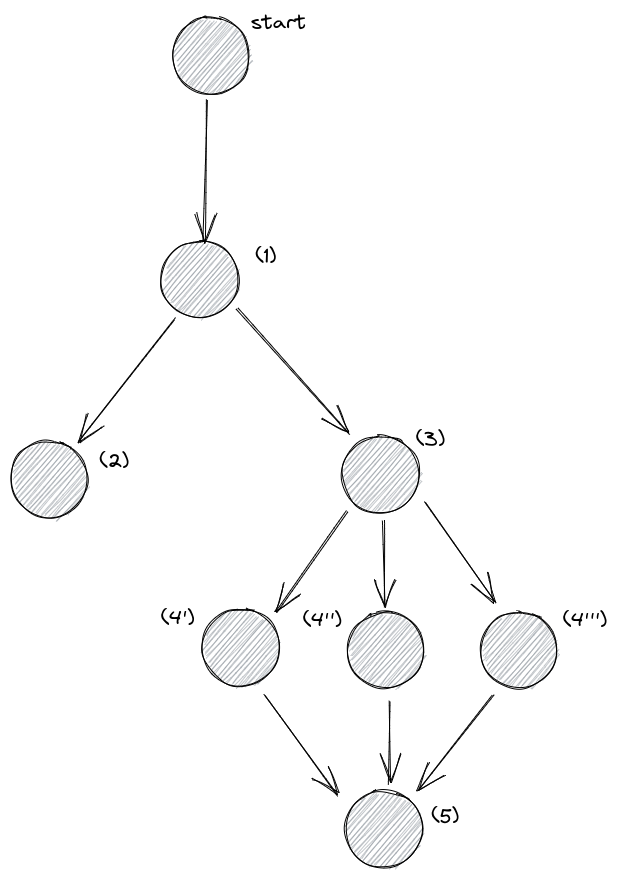  

Ce `DAG` permet ainsi de nourrir un dashboard lancé dans un `docker-compose.yml` dédié et disponible sur le port `8050` de la machine. Ce `DAG` devra être exécuté toutes les minutes pour mettre à jour régulièrement le dashboard ainsi que le modèle de prédiction.  

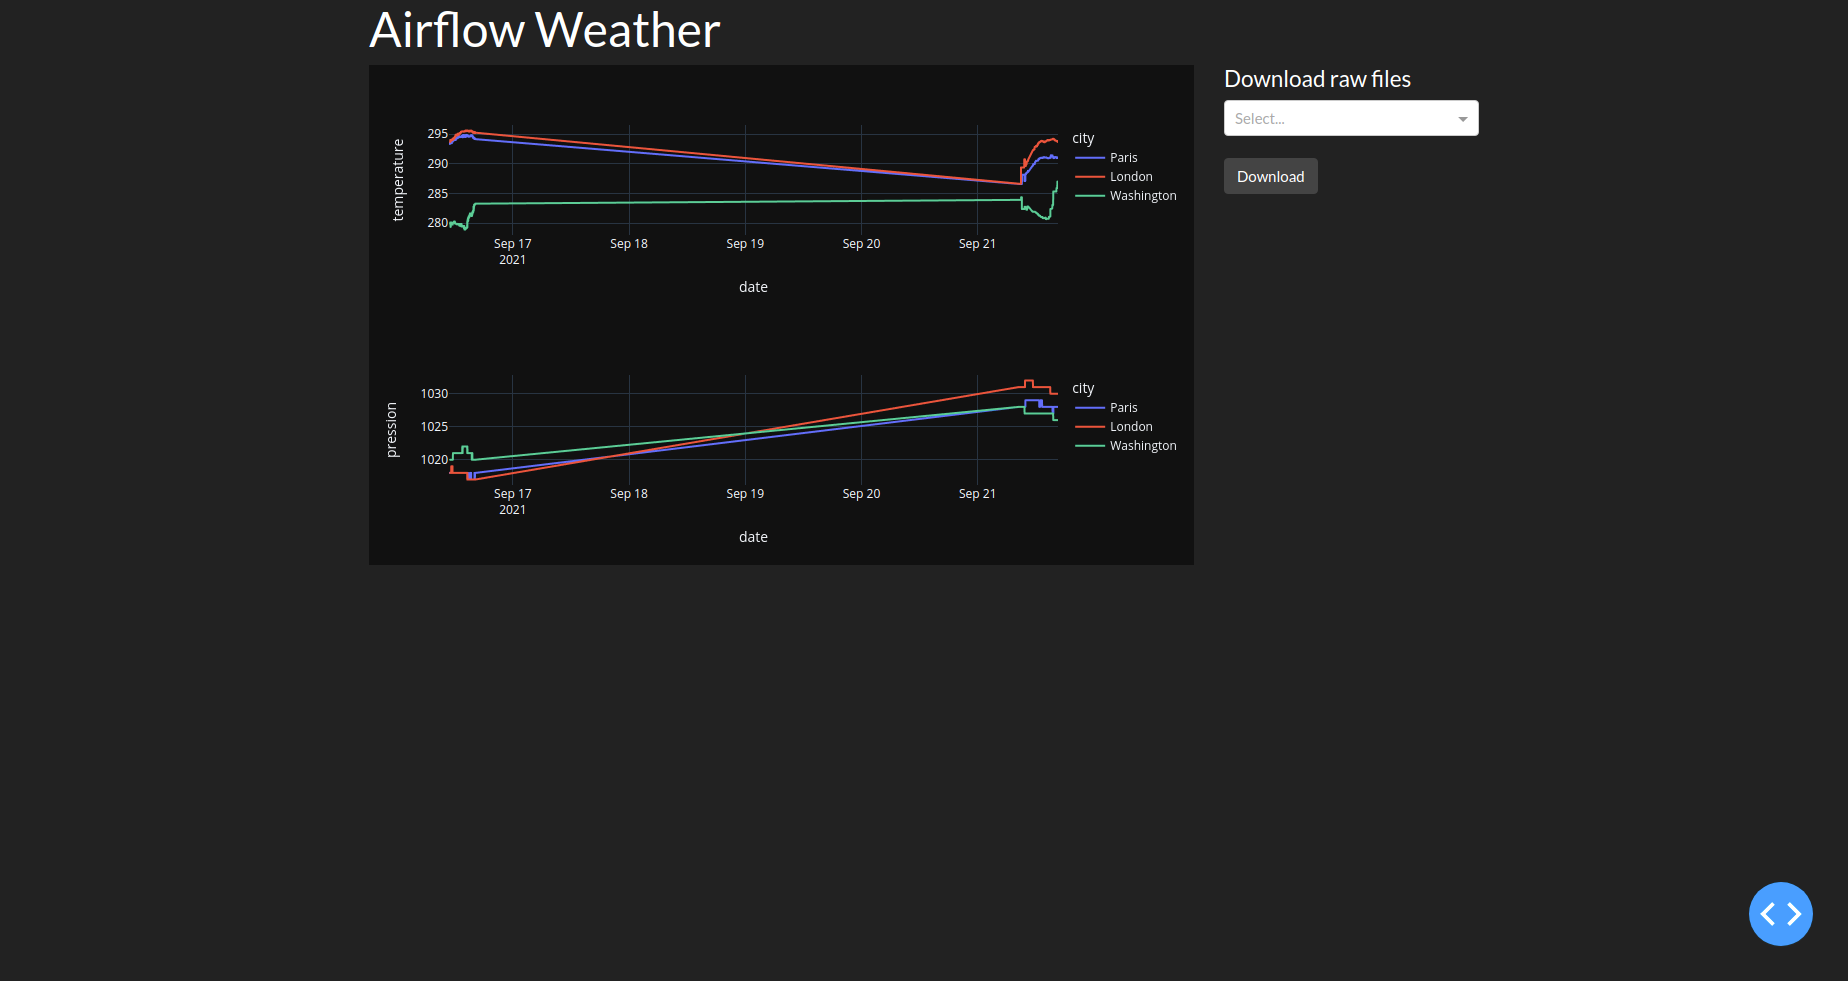  

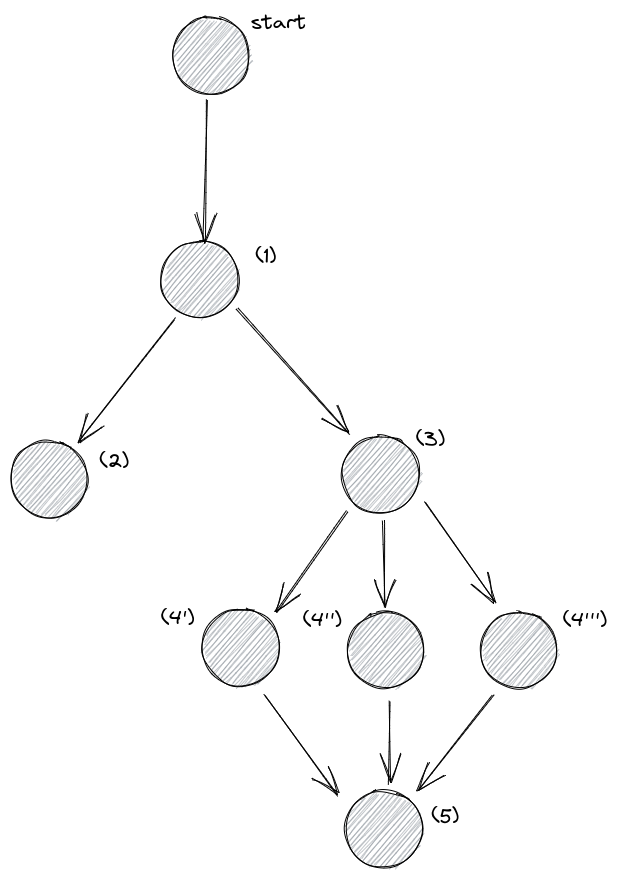

### **Pré-requis**

Pour commencer l'évaluation, il faut télécharger un autre fichier `docker-compose.yaml` et créer des dossiers pour stocker les données:

Attention ! Si vous souhaitez conserver le premier fichier `docker-compose.yml` utilisé dans le cours, vous pouvez utiliser un nouveau dossier. Il vous faudra, dans ce cas, refaire les étapes d'initialisation du premier cours !

Si l'interface `Airflow` n'est pas fonctionnelle, c'est à cause des résidus du premier `docker-compose.yml`. Je vous invite à partir d'une machine vide, donc il faudra faire un reset. Avant de le faire, récupérez l'ensemble des fichiers qui vous sont importants.

> Exécutez la commande suivante
> 

```bash
# shutting down previous containers
docker-compose down

# deleting previous docker-compose
rm docker-compose.yaml

# downloading new docker-compose.yml file
wget https://dst-de.s3.eu-west-3.amazonaws.com/airflow_fr/eval/docker-compose.yaml

# creating directories
mkdir ./dags ./logs ./plugins
mkdir clean_data
mkdir raw_files

echo -e "AIRFLOW_UID=$(id -u)\nAIRFLOW_GID=0" > .env

docker-compose up airflow-init

wget https://dst-de.s3.eu-west-3.amazonaws.com/airflow_avance_fr/eval/data.csv -O clean_data/data.csv
echo '[]' >> raw_files/null_file.json

# starting docker-compose
docker-compose up -d

```

### **(1) Récupération de données depuis l'API OpenWeatherMap**

[OpenWeatherMap](https://openweathermap.org/) est une API de données météo. Avec un plan gratuit, on peut requêter l'API jusqu'à 60 fois par minute, ce qui sera amplement suffisant pour notre cas d'usage.

> Créez un compte sur OpenWeatherMap et connectez vous au compte
> 

Une fois connecté, on peut se rendre dans le menu [`My API keys`](https://home.openweathermap.org/api_keys). Vous pourrez alors voir votre clef d'API par défaut.

Pour obtenir les données en temps réel de la météo quelque part dans le monde, on peut faire une requête sur l'API `current` dont la documentation est disponible [ici](https://openweathermap.org/current). Pour obtenir des données, on doit faire une requête `HTTP` de type `GET` à l'URL suivante, `https://api.openweathermap.org/data/2.5/weather?q=city_name&appid=API_key`, en remplaçant votre `api_key` par la clef d'API obtenue à l'étape précédente et `city_name` par le nom d'une ville.

> Essayez la commande suivante en remplaçant api_key par votre clef
> 

```
curl -X GET "https://api.openweathermap.org/data/2.5/weather?q=paris&appid=API_key"

```

La première tâche `(1)` consiste donc en la récupération des données depuis `OpenWeatherMap`: on pourra faire plusieurs requêtes pour avoir les données sur plusieurs villes. Pour cela, on stockera une `Variable Airflow` nommée `cities`. Dans notre solution, nous utilisons `['paris', 'london', 'washington']` mais vous pouvez choisir d'autres villes.

Cette tâche doit stocker les données au format `json` dans un fichier dont le nom correspond à l'heure et la date de la récolte de donnée: `2021-01-01 00:00.json`. Ce fichier devra être créé dans le dossier `/app/raw_files`.

On pourra utiliser les librairies `requests` et `json`.

### **(2) et (3) transformation des données**

Les tâches `(2)` et `(3)` consiste à lire le contenu du dossier `/app/raw_files` et transformer les données au format `csv`.

On pourra utiliser la fonction suivante:

```python
def transform_data_into_csv(n_files=None, filename='data.csv'):
    parent_folder = '/app/raw_files'
    files = sorted(os.listdir(parent_folder), reverse=True)
    if n_files:
        files = files[:n_files]

    dfs = []

    for f in files:
        with open(os.path.join(parent_folder, f), 'r') as file:
            data_temp = json.load(file)
        for data_city in data_temp:
            dfs.append(
                {
                    'temperature': data_city['main']['temp'],
                    'city': data_city['name'],
                    'pression': data_city['main']['pressure'],
                    'date': f.split('.')[0]
                }
            )

    df = pd.DataFrame(dfs)

    print('\n', df.head(10))

    df.to_csv(os.path.join('/app/clean_data', filename), index=False)

```

La tâche `(2)` devra prendre les 20 derniers fichiers, les concaténer et les transformer dans un fichier `data.csv` alors que la tâche `(3)` devra prendre en compte tous les fichiers dans le dossier et créer un fichier `fulldata.csv`.

Le premier fichier sera utilisé par le dashboard pour visualiser les dernières observations alors que le deuxième fichier sera utilisé dans la suite du `DAG` pour entraîner un algorithme.

### **(4) et (5) entraînement de modèles et sélection du plus performant**

Les tâches `(4')`, `(4'')` et `(4''')` correspondent à l'entraînement de différents modèles de régression (respectivement `LinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`). Une fois ces modèles entraînés et testés avec une méthode de validation croisée, on pourra utiliser un `XCom` pour transmettre la valeur du score de validation. La tâche `(5)` permettra de choisir le meilleur modèle, de le réentraîner sur toutes les données et de le sauvegarder.

Ces deux tâches pourraient classiquement être traitées par un script similaire à celui-ci:

```python
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from joblib import dump

def compute_model_score(model, X, y):
    # computing cross val
    cross_validation = cross_val_score(
        model,
        X,
        y,
        cv=3,
        scoring='neg_mean_squared_error')

    model_score = cross_validation.mean()

    return model_score

def train_and_save_model(model, X, y, path_to_model='./app/model.pckl'):
    # training the model
    model.fit(X, y)
    # saving model
    print(str(model), 'saved at ', path_to_model)
    dump(model, path_to_model)

def prepare_data(path_to_data='/app/clean_data/fulldata.csv'):
    # reading data
    df = pd.read_csv(path_to_data)
    # ordering data according to city and date
    df = df.sort_values(['city', 'date'], ascending=True)

    dfs = []

    for c in df['city'].unique():
        df_temp = df[df['city'] == c]

        # creating target
        df_temp.loc[:, 'target'] = df_temp['temperature'].shift(1)

        # creating features
        for i in range(1, 10):
            df_temp.loc[:, 'temp_m-{}'.format(i)
                        ] = df_temp['temperature'].shift(-i)

        # deleting null values
        df_temp = df_temp.dropna()

        dfs.append(df_temp)

    # concatenating datasets
    df_final = pd.concat(
        dfs,
        axis=0,
        ignore_index=False
    )

    # deleting date variable
    df_final = df_final.drop(['date'], axis=1)

    # creating dummies for city variable
    df_final = pd.get_dummies(df_final)

    features = df_final.drop(['target'], axis=1)
    target = df_final['target']

    return features, target

if __name__ == '__main__':

    X, y = prepare_data('./clean_data/fulldata.csv')

    score_lr = compute_model_score(LinearRegression(), X, y)
    score_dt = compute_model_score(DecisionTreeRegressor(), X, y)

    # using neg_mean_square_error
    if score_lr < score_dt:
        train_and_save_model(
            LinearRegression(),
            X,
            y,
            '/app/clean_data/best_model.pickle'
        )
    else:
        train_and_save_model(
            DecisionTreeRegressor(),
            X,
            y,
            '/app/clean_data/best_model.pickle'
        )

```

On pourra réutiliser les fonctions utilisées dans ce script pour créer ces tâches.

### **Quelques conseils et rappels**

- N'hésitez pas à tester vos fonctions en dehors de Airflow: vous perdrez beaucoup moins de temps à les utiliser en dehors de Airflow plutôt qu'à l'intérieur d'un `DAG`
- Une fois que le code fonctionne, on peut implémenter une tâche pour que l'intégrer à un `DAG`: essayez de faire tourner le `DAG` avec une première tâche puis une seconde ...
- En suivant exactement le script utilisé dans les tâches `(4)` et `(5)`, il faut avoir au moins 15 observations: lorsque vous avez construit la tâche `(1)` et qu'elle fonctionne correctement, laissez-la tourner une quinzaine de minutes seule.
- Le dashboard permet de concrétiser le cas d'utilisation mais c'est aussi un bon outil pour voir si le `DAG` fonctionne correctement: vous pouvez y voir les données traitées mais aussi les données brutes.
- La clef d'API est limitée en nombre de requêtes par minutes. Si jamais vous faîtes trop de requêtes en même temps, la clef sera indisponible pendant quelques instants.
- vous pouvez toujours vérifier que les fichiers sont bien créés en observant le contenu des dossiers `clean_data` et `raw_files` qui sont montés sur les dossiers `/app/clean_data` et `/app/raw_files` de docker-compose. (Si vous n'êtes pas familier avec docker-compose, considérer que depuis l'extérieur de Airflow, `/app/clean_data` correspond au dossier `clean_data` présent dans le répertoire de travail).
- Utilisez des Taskgroups pour regrouper certaines tâches ensemble.
- Merci de respecter le nom des variables ainsi que les `Variables` Airflow pour que la correction soit plus simple pour nous !

### **Attendus**

Pour valider le module, il faut rendre un fichier Python contenant la définition compléte du `DAG`. Vous pouvez ajouter un fichier explicatif des différents choix que vous avez faits. N'oubliez pas d'envoyer votre examen sous le format d'une archive zip ou tar, auquel cas il ne sera pas pris en compte.

Bon courage !